In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Класс-генератор данных.
# Используется для последовательной выдачи пакетов данных.
# Удобно с точки зрения отслеживания конца эпохи.
# Обрабатывает граничный случай во время окончания эпохи,
# когда еще неотправленных на обучение данных остается меньше, чем размер пакета данных.
class DataGenerator:
    def __init__(self, X, y, batch_size):
        self.curr_i = 0
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_overflowed = False
    
    def __next__(self):
        rem = 0
        X_batch = self.X[self.curr_i: self.curr_i + self.batch_size]
        y_batch = self.y[self.curr_i: self.curr_i + self.batch_size]
        rem = self.X.shape[0] - self.curr_i
        if rem <= self.batch_size:
            self.curr_i = self.batch_size - rem
            X_batch = np.vstack((self.X[-rem:], self.X[:self.curr_i]))
            y_batch = np.hstack((self.y[-rem:], self.y[:self.curr_i]))
            self.is_overflowed = True
        else:
            self.curr_i += self.batch_size
            self.is_overflowed = False
        yield X_batch
        yield y_batch

In [3]:
class LinearRegresion:
    def __init__(self, random_state=None):
        self.random_state = random_state
        self.W = None
        self.b = None
    
    # Функция добавления к исходным данным дополнительного столбца
    # (нужно для сдвигового коэффициента)
    def __add_ones_col(self, data):
        ones = np.ones((data.shape[0], 1))
        return np.append(ones, data, axis=1)
    
    # Функция потери mse
    def __mse_loss(self, pred, true):
        return np.mean(np.power(pred - true, 2))
    
    # Градиент функции потерь по весам
    def __mse_loss_derivative(self, batch, pred, true):
        return 2 * np.mean((batch.T * (pred - true)).T, axis=0)
    
    # Функция тренировки модели
    def fit(self, X_train, y_train, n_epochs=10, lr=1e-1, batch_size=16, verbose=False):
        # X_train:     признаковое описание объектов обучающей выборки
        # y_train:     метки объектов обучающей выборки
        # n_epochs:    количество эпох обучения
        # lr: скорость обучения
        # batch_size:  размер пакета данных
        
        np.random.seed(self.random_state)
        history = {"loss": []}
        
        # Добавляем дополнительный столбец в датасет для коэффициента сдвига
        X_train = self.__add_ones_col(X_train)
        
        # Инициализируем веса
        self.W = np.random.normal(0.0, 1.0, X_train.shape[1])
        
        # Инициализируем генератор тренировочных данных
        data_gen = DataGenerator(X_train, y_train, batch_size)
        for epoch in range(n_epochs):
            # Получаем первый пакет данных
            X_batch, y_batch = next(data_gen)
            batches_count = 0
            epoch_loss = 0.0
            
            # Пока текущая эпоха не закончилась 
            # (пока не произошло прохода по всем данным)
            while not data_gen.is_overflowed:
                
                # Рассчитываем линейные комбинации для данных и весов
                pred = X_batch.dot(self.W)
                
                # Подсчитываем градиент весов на пакете данных и отнимаем его от матрицы весов,
                # делая шаг в сторону минимума. lr - коэффициент шага (скорость обучения)
                dW = self.__mse_loss_derivative(X_batch, pred, y_batch)
                self.W = self.W - lr * dW
                
                # Сохраняем информацию о заучивании на текущем пакете
                epoch_loss += np.sum(self.__mse_loss(X_batch.dot(self.W), y_batch))
                batches_count += 1
                
                # Получаем следующий пакет данных
                X_batch, y_batch = next(data_gen)
            
            epoch_loss /= (batches_count * batch_size)
            if verbose:
                print("Эпоха: %s, loss: %s, root_loss: %s" % (epoch + 1, epoch_loss, np.sqrt(epoch_loss)))
            history['loss'].append(epoch_loss)
        return history
    
    # Функция предсказания
    def predict(self, X_test):
        # Так же, как и во время тренировки, добавляем столбец для коэффициента сдвига
        X_test = self.__add_ones_col(X_test)
        predictions = []
        
        # Предсказание - это линейная комбинация данных и заученных весов.
        for X in X_test:
            predictions.append(X.dot(self.W))
        return np.array(predictions)

In [4]:
# Загружаем датасет
df = pd.read_csv("brain_size.csv", sep='\t')
df.head()

Gender  FSIQ  VIQ  PIQ Weight Height  MRICount
0  Female   133  132  124    118   64.5    816932
1    Male   140  150  124      .   72.5   1001121
2    Male   139  123  150    143   73.3   1038437
3    Male   133  129  128    172   68.8    965353
4  Female   137  132  134    147     65    951545

In [5]:
# Заменяем строковое описание пола на числовое
df.Gender.replace({'Female': 0, 'Male': 1}, inplace=True)

# Приводим все столбцы к наиболее подходящему числовому типу
# и заполняем пропущенные значения средними по столбцу
df = df.apply(pd.to_numeric, errors='coerce')
df.fillna(df.mean(), inplace=True)
df.head()

Gender  FSIQ  VIQ  PIQ      Weight  Height  MRICount
0       0   133  132  124  118.000000    64.5    816932
1       1   140  150  124  151.052632    72.5   1001121
2       1   139  123  150  143.000000    73.3   1038437
3       1   133  129  128  172.000000    68.8    965353
4       0   137  132  134  147.000000    65.0    951545

In [6]:
# Стандартизируем данные
t_df = df.drop(columns=['MRICount'])
df.iloc[:, :-1] = (t_df - t_df.mean()) / t_df.std()
df.head()

Gender      FSIQ       VIQ       PIQ    Weight    Height  MRICount
0 -0.987421  0.811807  0.832059  0.577410 -1.445330 -1.020932    816932
1  0.987421  1.102480  1.594251  0.577410  0.000000  1.007927   1001121
2  0.987421  1.060955  0.450963  1.734454 -0.352127  1.210813   1038437
3  0.987421  0.811807  0.705027  0.755416  0.915989  0.069579    965353
4 -0.987421  0.977906  0.832059  1.022427 -0.177214 -0.894129    951545

In [7]:
# Разделяем данные на признаки и метки
X_train, y_train = df.drop(columns=['MRICount']).values, df['MRICount'].values

In [8]:
reg = LinearRegresion(random_state=42)
history = reg.fit(X_train, y_train, n_epochs=150, lr=1e-2, batch_size=8, verbose=True)
y_pred = reg.predict(X_train)

# Видно, что значение функции потерь - величина порядка 10^9.
# Это происходит из-за того, формула MSE, рассчитываемая для 
# функции потерь, возвращает результат в квадратных единицах.
# root_loss - показывает результат в реальных единицах (в данном случае, в пикселах)

Эпоха: 1, loss: 92088575452.91138, root_loss: 303460.99494483863
Эпоха: 2, loss: 77756993626.41232, root_loss: 278849.4103031461
Эпоха: 3, loss: 65866769941.92584, root_loss: 256645.2219347281
Эпоха: 4, loss: 55938549891.60145, root_loss: 236513.3186347049
Эпоха: 5, loss: 47605455551.1165, root_loss: 218186.74467326494
Эпоха: 6, loss: 40582010202.94462, root_loss: 201449.7709180743
Эпоха: 7, loss: 34642670963.6362, root_loss: 186125.41729607002
Эпоха: 8, loss: 29606802655.891018, root_loss: 172066.27402222384
Эпоха: 9, loss: 25328005456.259533, root_loss: 159147.74725474292
Эпоха: 10, loss: 21686413705.980637, root_loss: 147263.07651947462
Эпоха: 11, loss: 18583044929.26454, root_loss: 136319.64249243226
Эпоха: 12, loss: 15935581495.194895, root_loss: 126236.2130895683
Эпоха: 13, loss: 13675167533.609818, root_loss: 116940.87195506034
Эпоха: 14, loss: 11743936404.136463, root_loss: 108369.44405198572
Эпоха: 15, loss: 10093072455.988651, root_loss: 100464.28447955349
Эпоха: 16, loss: 86

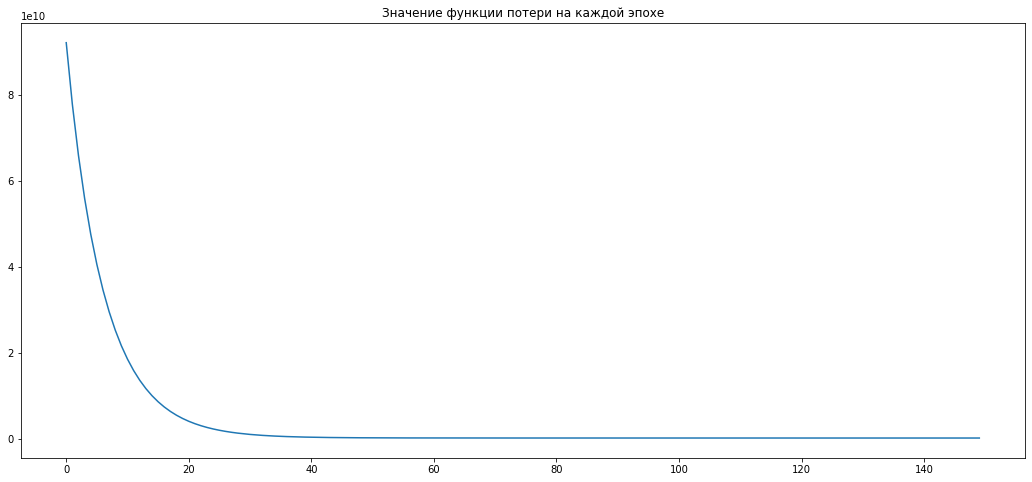

In [11]:
xs = np.arange(0, len(history['loss']))
plt.figure(figsize=(18, 8))
plt.plot(xs, history['loss'])
plt.title("Значение функции потери на каждой эпохе")
plt.show()

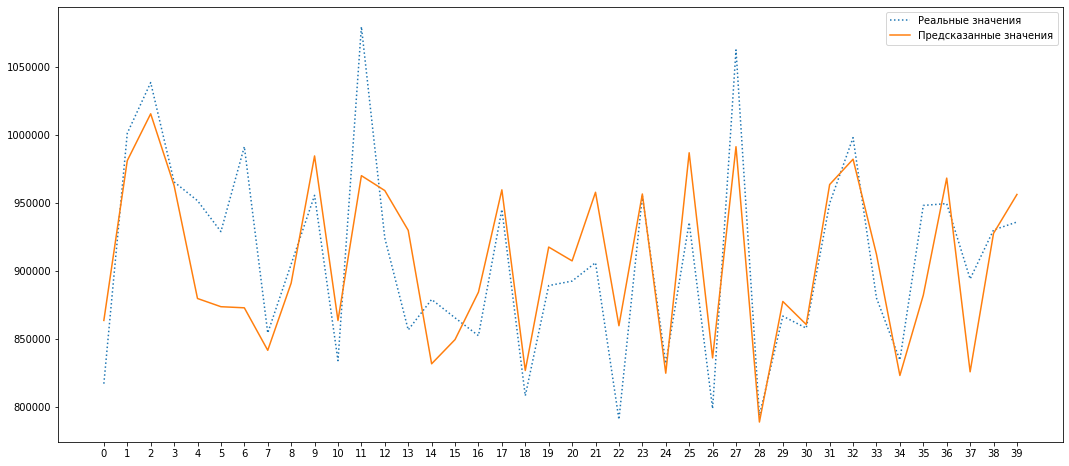

In [12]:
plt.figure(figsize=(18, 8))
plt.plot(np.arange(y_pred.shape[0]), y_train, linestyle=':')
plt.plot(np.arange(y_pred.shape[0]), y_pred)
plt.xticks(np.arange(y_pred.shape[0]))
plt.legend(["Реальные значения", "Предсказанные значения"])
plt.show()